<a href="https://colab.research.google.com/github/alansshots/federated-learning-institute-project/blob/main/Straggler_timeout_client_dropping_MNIST_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
!pip install torch torchvision


--- Round 1/7 ---
Selected clients this round: [0, 1, 2]
Client 0 training time: 1.15 seconds
Client 1 timed out
Client 1 training time: 3.11 seconds
Client 2 training time: 1.05 seconds
2 out of 5 clients participated.
Accuracy: 0.2618, F1 Score: 0.2130, Loss: 2.2160

--- Round 2/7 ---
Selected clients this round: [2, 0, 1]
Adaptive timeout for this round: 2.56 seconds
Client 2 timed out
Client 2 training time: 2.70 seconds
Client 0 training time: 1.03 seconds
Client 1 timed out
Client 1 training time: 2.60 seconds
1 out of 5 clients participated.
Accuracy: 0.4125, F1 Score: 0.3687, Loss: 2.0246

--- Round 3/7 ---
Selected clients this round: [0, 2, 1]
Adaptive timeout for this round: 2.84 seconds
Client 0 timed out
Client 0 training time: 2.94 seconds
Client 2 training time: 2.13 seconds
Client 1 training time: 1.03 seconds
2 out of 5 clients participated.
Accuracy: 0.6170, F1 Score: 0.5842, Loss: 1.8100

--- Round 4/7 ---
Selected clients this round: [0, 2, 1]
Adaptive timeout for 

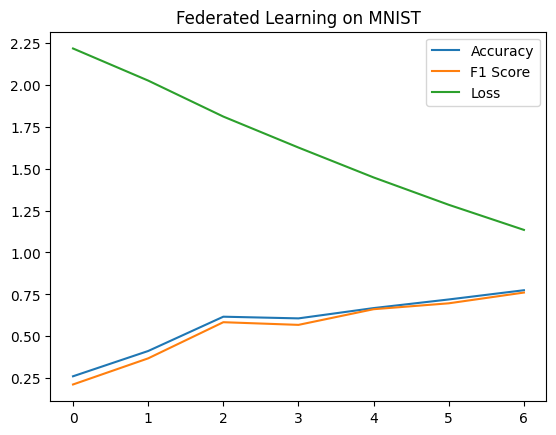

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, F1Score
from torchvision import datasets, transforms
from copy import deepcopy
import numpy as np
import torchvision.models as models
from tqdm.autonotebook import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import time
import random

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def resnet18(num_classes, **kwargs):
    original_model = models.resnet18(**kwargs)
    original_model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
    original_model.maxpool = nn.Identity()
    original_model.fc = nn.Linear(512, num_classes)
    return original_model

def uniform_allocation(Y, num_clients):
    indices = np.arange(len(Y))
    np.random.shuffle(indices)
    indices_split = np.array_split(indices, num_clients)
    return [list(idx) for idx in indices_split]

# Hyperparameters
num_clients = 5
batch_size = 64
global_epochs = 7
local_epochs = 1
learning_rate = 1e-2
loss_fn = nn.CrossEntropyLoss()
#timeout_seconds = 3

# Model
model = resnet18(10)
client_models = [deepcopy(model).to(device) for _ in range(num_clients)]
client_optims = [optim.SGD(cm.parameters(), lr=learning_rate) for cm in client_models]

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_dataset.data = train_dataset.data[:5000]
train_dataset.targets = train_dataset.targets[:5000]
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_subsets = uniform_allocation(train_dataset.targets, num_clients)
train_subsets = [torch.utils.data.Subset(train_dataset, indices) for indices in train_subsets]
train_subset_dataloaders = [DataLoader(ds, batch_size=batch_size, shuffle=True) for ds in train_subsets]
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def fed_avg(models):
    avg_model = deepcopy(models[0]).to(device)
    avg_state_dict = avg_model.state_dict()
    with torch.no_grad():
        for key in avg_state_dict.keys():
            if not avg_state_dict[key].dtype.is_floating_point:
                avg_state_dict[key].copy_(models[0].state_dict()[key])
                continue
            tmp = torch.zeros_like(avg_state_dict[key])
            for m in models:
                tmp += m.state_dict()[key]
            avg_state_dict[key].copy_(tmp / len(models))
    return avg_model

# client performance
client_times = [0.0 for _ in range(num_clients)]
client_counts = [0 for _ in range(num_clients)]

global_model = deepcopy(model).to(device)
acc_list, f1_list, loss_list = [], [], []

for round in range(global_epochs):
    print(f"\n--- Round {round+1}/{global_epochs} ---")
    participating_clients = []

    # average training time, select top 3 fastest clients
    avg_times = [
        client_times[i] / client_counts[i] if client_counts[i] > 0 else float('inf')
        for i in range(num_clients)
    ]
    selected_clients = sorted(range(num_clients), key=lambda i: avg_times[i])[:3]
    print(f"Selected clients this round: {selected_clients}")

        # Dynamically adjust timeout
    filtered_avg_times = [t for t in avg_times if t != float('inf')]
    if filtered_avg_times:
        estimated_round_time = np.percentile(filtered_avg_times, 75)
        timeout_seconds = estimated_round_time * 1.2
        print(f"Adaptive timeout for this round: {timeout_seconds:.2f} seconds")
    else:
        timeout_seconds = 3

    for i in selected_clients:
        client_models[i].load_state_dict(global_model.state_dict())
        client_models[i].train()
        start_time = time.time()

        # --- simulated straggler setup ---
        straggler_delay = random.uniform(1.5, 3) if random.random() < 0.4 else 0

        try:
            for epoch in range(local_epochs):
                for x, y in train_subset_dataloaders[i]:

                    # --- simulate slow clients ---
                    if straggler_delay:
                        time.sleep(straggler_delay / (local_epochs * len(train_subset_dataloaders[i])))

                    # --- timeout check ---
                    if time.time() - start_time > timeout_seconds:
                        raise TimeoutError(f"Client {i} timed out")

                    x, y = x.to(device), y.to(device)
                    client_optims[i].zero_grad()
                    y_pred = client_models[i](x)
                    loss = loss_fn(y_pred, y)
                    loss.backward()
                    client_optims[i].step()

            participating_clients.append(client_models[i])
        except TimeoutError as e:
            print(e)

        end_time = time.time()
        print(f"Client {i} training time: {end_time - start_time:.2f} seconds")
        client_times[i] += end_time - start_time
        client_counts[i] += 1

    print(f"{len(participating_clients)} out of {num_clients} clients participated.")

    if participating_clients:
        global_model.load_state_dict(fed_avg(participating_clients).state_dict())
    else:
        print("No clients completed training in this round.")

    global_model.eval()
    correct, total, test_loss = 0, 0, 0
    y_true, y_pred_all = [], []

    with torch.no_grad():
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            logits = global_model(x)
            loss = loss_fn(logits, y)
            test_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            y_true.extend(y.cpu().numpy())
            y_pred_all.extend(preds.cpu().numpy())

    acc = correct / total
    f1 = f1_score(y_true, y_pred_all, average='macro')
    acc_list.append(acc)
    f1_list.append(f1)
    loss_list.append(test_loss / len(test_dataloader))

    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, Loss: {loss_list[-1]:.4f}")

plt.plot(acc_list, label="Accuracy")
plt.plot(f1_list, label="F1 Score")
plt.plot(loss_list, label="Loss")
plt.legend()
plt.title("Federated Learning on MNIST")
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



--- Round 1/10 ---
Selected clients this round: [0, 1, 2]
Client 0 training time: 2.21 seconds
Client 1 training time: 1.10 seconds
Client 2 training time: 1.09 seconds
3 out of 5 clients participated.
Accuracy: 0.2225, F1 Score: 0.1689, Loss: 2.0967

--- Round 2/10 ---
Selected clients this round: [2, 1, 0]
Adaptive timeout for this round: 1.98 seconds
Client 2 training time: 1.09 seconds
Client 1 training time: 1.09 seconds
Client 0 training time: 1.11 seconds
3 out of 5 clients participated.
Accuracy: 0.2495, F1 Score: 0.1931, Loss: 1.9075

--- Round 3/10 ---
Selected clients this round: [2, 1, 0]
Adaptive timeout for this round: 1.65 seconds
Client 2 timed out
Client 2 training time: 1.72 seconds
Client 1 training time: 1.07 seconds
Client 0 training time: 1.11 seconds
2 out of 5 clients participated.
Accuracy: 0.3356, F1 Score: 0.3112, Loss: 1.7832

--- Round 4/10 ---
Selected clients this round: [1, 2, 0]
Adaptive timeout for this round: 1.66 seconds
Client 1 training time: 1.08

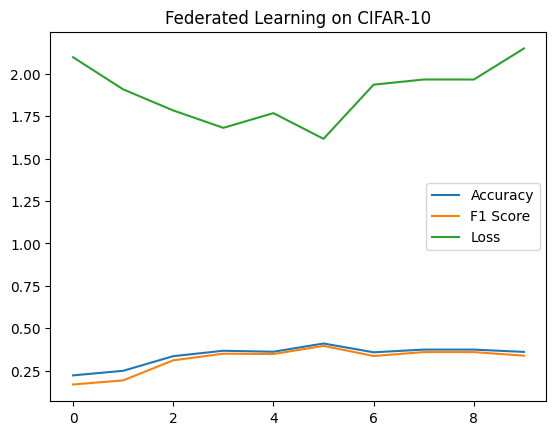

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from sklearn.metrics import f1_score
from copy import deepcopy

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Modified ResNet18 model for CIFAR-10
def resnet18(num_classes, **kwargs):
    original_model = models.resnet18(pretrained=False, **kwargs)
    original_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    original_model.maxpool = nn.Identity()
    original_model.fc = nn.Linear(512, num_classes)
    return original_model

def uniform_allocation(Y, num_clients):
    indices = np.arange(len(Y))
    np.random.shuffle(indices)
    indices_split = np.array_split(indices, num_clients)
    return [list(idx) for idx in indices_split]

# Hyperparameters
num_clients = 5
batch_size = 64
global_epochs = 10
local_epochs = 1
learning_rate = 1e-2
loss_fn = nn.CrossEntropyLoss()

# Model
model = resnet18(10)
client_models = [deepcopy(model).to(device) for _ in range(num_clients)]
client_optims = [optim.SGD(cm.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4) for cm in client_models]

# CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_dataset.data = train_dataset.data[:5000]
train_dataset.targets = train_dataset.targets[:5000]
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_subsets = uniform_allocation(train_dataset.targets, num_clients)
train_subsets = [Subset(train_dataset, indices) for indices in train_subsets]
train_subset_dataloaders = [DataLoader(ds, batch_size=batch_size, shuffle=True) for ds in train_subsets]
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def fed_avg(models):
    avg_model = deepcopy(models[0]).to(device)
    avg_state_dict = avg_model.state_dict()
    with torch.no_grad():
        for key in avg_state_dict.keys():
            if not avg_state_dict[key].dtype.is_floating_point:
                avg_state_dict[key].copy_(models[0].state_dict()[key])
                continue
            tmp = torch.zeros_like(avg_state_dict[key])
            for m in models:
                tmp += m.state_dict()[key]
            avg_state_dict[key].copy_(tmp / len(models))
    return avg_model

# client performance
client_times = [0.0 for _ in range(num_clients)]
client_counts = [0 for _ in range(num_clients)]

global_model = deepcopy(model).to(device)
acc_list, f1_list, loss_list = [], [], []

for round in range(global_epochs):
    print(f"\n--- Round {round+1}/{global_epochs} ---")
    participating_clients = []

    # average training time, select top 3 fastest clients
    avg_times = [
        client_times[i] / client_counts[i] if client_counts[i] > 0 else float('inf')
        for i in range(num_clients)
    ]
    selected_clients = sorted(range(num_clients), key=lambda i: avg_times[i])[:3]
    print(f"Selected clients this round: {selected_clients}")

    # Dynamically adjust timeout
    filtered_avg_times = [t for t in avg_times if t != float('inf')]
    if filtered_avg_times:
        estimated_round_time = np.percentile(filtered_avg_times, 75)
        timeout_seconds = estimated_round_time * 1.2
        print(f"Adaptive timeout for this round: {timeout_seconds:.2f} seconds")
    else:
        timeout_seconds = 3

    for i in selected_clients:
        client_models[i].load_state_dict(global_model.state_dict())
        client_models[i].train()
        start_time = time.time()

        # --- simulated straggler setup ---
        straggler_delay = random.uniform(1.5, 3) if random.random() < 0.4 else 0

        try:
            for epoch in range(local_epochs):
                for x, y in train_subset_dataloaders[i]:

                    # --- simulate slow clients ---
                    if straggler_delay:
                        time.sleep(straggler_delay / (local_epochs * len(train_subset_dataloaders[i])))

                    # --- timeout check ---
                    if time.time() - start_time > timeout_seconds:
                        raise TimeoutError(f"Client {i} timed out")

                    x, y = x.to(device), y.to(device)
                    client_optims[i].zero_grad()
                    y_pred = client_models[i](x)
                    loss = loss_fn(y_pred, y)
                    loss.backward()
                    client_optims[i].step()

            participating_clients.append(client_models[i])
        except TimeoutError as e:
            print(e)

        end_time = time.time()
        print(f"Client {i} training time: {end_time - start_time:.2f} seconds")
        client_times[i] += end_time - start_time
        client_counts[i] += 1

    print(f"{len(participating_clients)} out of {num_clients} clients participated.")

    if participating_clients:
        global_model.load_state_dict(fed_avg(participating_clients).state_dict())
    else:
        print("No clients completed training in this round.")

    global_model.eval()
    correct, total, test_loss = 0, 0, 0
    y_true, y_pred_all = [], []

    with torch.no_grad():
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            logits = global_model(x)
            loss = loss_fn(logits, y)
            test_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            y_true.extend(y.cpu().numpy())
            y_pred_all.extend(preds.cpu().numpy())

    acc = correct / total
    f1 = f1_score(y_true, y_pred_all, average='macro')
    acc_list.append(acc)
    f1_list.append(f1)
    loss_list.append(test_loss / len(test_dataloader))

    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, Loss: {loss_list[-1]:.4f}")

plt.plot(acc_list, label="Accuracy")
plt.plot(f1_list, label="F1 Score")
plt.plot(loss_list, label="Loss")
plt.legend()
plt.title("Federated Learning on CIFAR-10")
plt.show()

# Understanding Federated Learning with Over-Selection

This notebook demonstrates a simulated Federated Learning (FL) setup, focusing on a technique to mitigate the impact of "stragglers" (clients that are slow or fail). The core idea implemented here is to dynamically select clients based on their historical performance (average training time) and set an adaptive timeout to exclude stragglers from the current round's aggregation.

The simulation will walk through the following steps, which are repeated for a specified number of global epochs (also known as communication rounds):

1. Initialization
*   **Model Definition**: We start by defining a neural network model. For this simulation, we'll use a modified ResNet-18 architecture. This is done in the `resnet18` function, which adjusts the first convolutional layer for single-channel grayscale images (MNIST) or three-channel images (CIFAR-10) and modifies the final fully connected layer for the number of classes.
*   **Client Setup**: A set of "clients" are created, each initially holding a copy of the global model's architecture. This is represented by creating a list of `client_models`, where each element is a deep copy of the initial model.
*   **Data Distribution**: The training data is partitioned and distributed among these clients, ensuring each client has its own local dataset. The `uniform_allocation` function is used to split the dataset indices among clients, and `torch.utils.data.Subset` and `DataLoader` are used to create the local datasets and dataloaders for each client.
*   **Global Model**: A central global model is initialized. This model will be progressively updated over each communication round. This is represented by the `global_model` variable.
*   **Hyperparameters**: Key parameters for the simulation are set, including:
    *   `num_clients`: The total number of clients available in the system.
    *   `local_epochs`: The number of training epochs each client performs locally.
    *   `learning_rate`: The learning rate for local client training, used to initialize the client optimizers.
    *   `global_epochs`: The total number of communication rounds.
    *   `batch_size`: The batch size for the dataloaders.
    *   `loss_fn`: The loss function used for training (CrossEntropyLoss).

2. Client Selection (based on historical performance and adaptive timeout)
In each global round, a subset of clients is chosen to participate.

Instead of a fixed number of invited clients, this simulation implements a dynamic selection strategy:
*   **Historical Performance Tracking**: The `client_times` and `client_counts` lists track the cumulative training time and the number of rounds each client has participated in and completed without timing out.
*   **Client Ranking**: At the beginning of each round, the average training time for each client is calculated (`avg_times`). Clients are then ranked based on these average times.
*   **Top Client Selection**: The simulation selects the top `num_clients_invited` (which is hardcoded as 3 in this case) fastest clients to participate in the current round.
*   **Adaptive Timeout**: An adaptive timeout is calculated based on the percentile of the average training times of the participating clients. This helps to exclude stragglers who take significantly longer than the majority.
*   **Participation**: Only clients that complete their local training within the `timeout_seconds` are included in the `participating_clients` list for aggregation.

3. Local Training
*   Selected clients download the current global model parameters. This is simulated by loading the `global_model.state_dict()` into the `client_models`.
*   Each participating client trains the model on its local dataset for a specified number of `local_epochs`. This involves the standard training loop: forward pass, calculating the loss, backpropagation, and updating the client's model parameters using its optimizer.
*   A simulated straggler delay is introduced randomly to some clients during training to mimic real-world scenarios.
*   A check is performed in each training step to see if the client has exceeded the `timeout_seconds`. If so, a `TimeoutError` is raised, and the client's training for that round is stopped.

4. Aggregation (Federated Averaging - FedAvg)
*   After the local training phase, the server waits for the updates from the participating clients (those who completed training within the timeout).
*   The `fed_avg` function implements the Federated Averaging algorithm. It takes the state dictionaries of the participating client models and computes the average of their parameters.
*   The `global_model` is updated with this aggregated state dictionary. If no clients complete training in a round, the global model remains unchanged.

5. Global Model Evaluation
*   After aggregation, the updated global model is evaluated on a centralized test dataset to assess its performance.
*   The accuracy, F1 score, and loss of the global model on the test set are calculated and recorded.

6. Iteration
*   Steps 2-5 are repeated for the specified number of `global_epochs`.

7. Visualization
*   Finally, the recorded accuracy, F1 score, and loss over the global epochs are plotted to visualize the training progress and the performance of the federated learning model.